# Continuous Control

In this notebook, we attempt to solve Unity Reacher environment. We created two agents, A2C and PPO for the problem. 

---

### 1. Start the Environment

Import some necessary packages.

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np
from agent.ppo import PPO
from agent.a2c import A2C
from collections import deque
from agent.trainer import Trainer
from agent.model import ActorCritic
import matplotlib.pyplot as plt

In [2]:
# instantiate environment
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Define functions
``play_episode`` function plays a single episode on environment using the given ``agent``. If a ``trainer`` is provided, then it records the experience tuples in rollout buffer and executes an update when a batch is ready. If ``trainer`` is None, then the function runs in evaluation mode. Advantage of this approach is that we record experience data and make additional inference call only when we're training.

``train_agent`` function plays the episodes until the environment is solved. It also tracks the scores and outputs training statistics. 

In [4]:
def play_episode(env, brain_name, agent, trainer=None, max_t=1000):
    """play an episode and return the scores

    Args:
        env (UnityEnvironment): Unity 3D environment
        brain_name (String): Unity env brain name
        agent (object): Agent object
        trainer (object, optional): Training helper. Defaults to None.
        max_t (int, optional): Maximum time steps for the episode. Defaults to 1000.

    Returns:
        tuple(float): Mean and max score of the episode
    """
    env_info = env.reset(train_mode=True if trainer else False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    for t in range(max_t):
        actions, action_log_probs, state_values = agent.act(states)
        env_info = env.step(actions)[brain_name]

        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += rewards                                   # update the score (for each agent)

        if trainer:
            _, _, next_values = agent.act(next_states)
            trainer.step(states, actions, action_log_probs, rewards, state_values, next_values, dones)

        states = next_states
        if np.any(dones):
            break

    return np.mean(scores), np.max(scores)


def train_agent(agent, env, brain_name, trainer, num_episodes=1000, max_t=1000):
    """Train the agent

    Args:
        agent (object): Agent object to train
        env (UnityEnvironment): Unity 3D environment
        brain_name (String): Unity env brain name
        trainer (object): Trainer object
        num_episodes (int, optional): Max number of episodes to try. Defaults to 1000.
        max_t (int, optional): Max length of each episode. Defaults to 1000.

    Returns:
        [type]: [description]
    """
    scores_history = []
    scores_100 = deque(maxlen=100)
    for i_episode in range(1, num_episodes+1):
        score, max_score = play_episode(env, brain_name, agent, trainer=trainer, max_t=max_t)
        scores_history.append(score)
        scores_100.append(score)
        last_100_avg = '{:.2f}'.format(np.mean(scores_100)) if len(scores_100) == 100 else 'NA'

        print('\rEpisode {}\tAverage Score: {}\tLast Score: {:.2f}\tMax Score: {:.2f}'.format(i_episode, last_100_avg, score, max_score), end="")

        # if env is solved, break and save the model
        if len(scores_100) == 100 and np.mean(scores_100) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_100)))
            print('\nSaving agent...')
            agent.save('checkpoints/ppo_checkpoint_' + str(i_episode) + '.pth')
            break


    return scores_history

### 4. Launch training
Next we define the agent and trainer objects and launch the training.

In [5]:
# set device to cpu or cuda
device = torch.device('cpu')

#agent = A2C(ActorCritic, state_size, action_size, 1e-3, 1e-3, 0.99, device)
agent = PPO(ActorCritic, state_size, action_size, 1e-3, 1e-3, 0.99, device, K_epochs=8, eps_clip=0.2)
trainer = Trainer(agent, device=device, trajectory_length=1000, tau=0.95)

# train the agent
history = train_agent(agent, env, brain_name, trainer, num_episodes=1000, max_t=2000)

d:\learning\deep_reinforcement_learning_nanodegree\p2_continuous-control\agent\trainer.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  states = torch.FloatTensor(self.rollout_buffer.states).detach().to(self.device)


Episode 159	Average Score: 30.27	Last Score: 39.32	Max Score: 39.57
Environment solved in 159 episodes!	Average Score: 30.27

Saving agent...


### 5. Plot metrics

Text(0, 0.5, 'Score')

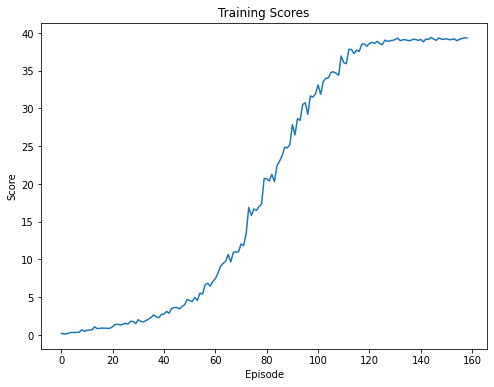

In [16]:
# plot the scores
plt.figure(figsize=(8,6))
plt.plot(history)
plt.title('Training Scores')
plt.xlabel('Episode')
plt.ylabel('Score')

Text(0.5, 1.0, 'Distribution Std')

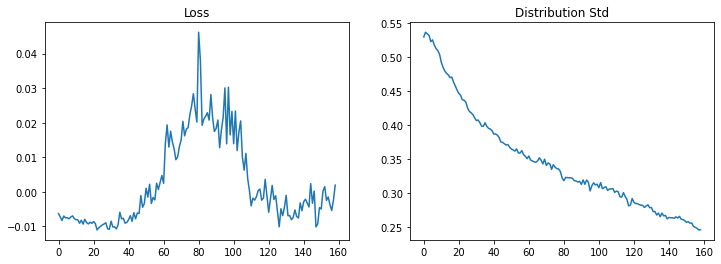

In [17]:
# plot loss and mean standard deviations of actions
fix, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(trainer.metrics['loss'])
axs[0].set_title('Loss')
axs[1].plot(trainer.metrics['std'])
axs[1].set_title('Distribution Std')

### 6. Validation
Next we will do a validation run by not passing a Trainer object.

In [10]:
# play an episode to visualize the agent in action
play_episode(env, brain_name, agent, trainer=None, max_t=2000)

(39.21699912343174, 39.64999911375344)

### 7. Shutdown
Shutdown the environment by running the following cell.

In [11]:
# close the environment
env.close()